# Set Up
File: example_db_use.py  
Date Created: 2018-10-20  
Author(s): Mahkah Wu  
Purpose: Explore outfielders within the Kaggle Baseball databank dataset

In [68]:
### Set Up
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import numpy as np

# Import database credentials from file ignored by GitHub and set up connection
from ignore import db_cred
conn = db_cred.connect_db()

# Retrieve Data

In [69]:
query = '''
select * from master as m
left join batting as b
on m."playerID" = b."playerID"
left join fielding as f
on f."playerID" = b."playerID" and f."yearID" = b."yearID"
'''

In [70]:
df = pd.read_sql(query, conn)
prefix_col = []
for i, col in enumerate(list(df)):
    if i < 24:
        prefix_col.append('m_{}'.format(col))
    elif i < 46:
        prefix_col.append('b_{}'.format(col))
    else:
        prefix_col.append('f_{}'.format(col))
df.columns = prefix_col
df.head()


,m_playerID,m_birthYear,m_birthMonth,m_birthDay,m_birthCountry,m_birthState,m_birthCity,m_deathYear,m_deathMonth,m_deathDay,...,f_InnOuts,f_PO,f_A,f_E,f_DP,f_PB,f_WP,f_SB,f_CS,f_ZR
0,barnero01,1850.0,5.0,8.0,USA,NY,Mount Morris,1915.0,2.0,5.0,...,NaN,42.0,61.0,15.0,10.0,NaN,NaN,NaN,NaN,NaN
1,barnero01,1850.0,5.0,8.0,USA,NY,Mount Morris,1915.0,2.0,5.0,...,NaN,44.0,64.0,21.0,3.0,NaN,NaN,NaN,NaN,NaN
2,barrofr01,1844.0,10.0,22.0,USA,OH,Hudson,1922.0,2.0,6.0,...,NaN,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,barrofr01,1844.0,10.0,22.0,USA,OH,Hudson,1922.0,2.0,6.0,...,NaN,28.0,1.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN
4,bealsto01,1850.0,8.0,NaN,USA,NY,New York,1915.0,10.0,2.0,...,NaN,9.0,7.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN


# Trim the dataset

In [71]:
df['m_playerID'].nunique()

19105

## Remove players that played before itegration (1947)

In [72]:
df = df[df.m_debut>datetime.datetime(1947, 1, 1).date()]
df['m_playerID'].nunique()

10979

## Remove players that played in few games
Let's explore the data to figure out where to draw the line.

The following plots are of games per season.

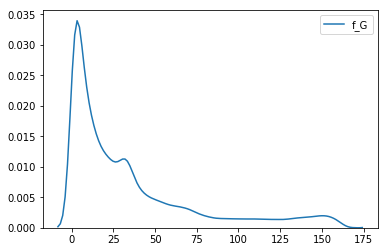

In [73]:
sns.kdeplot(df['f_G'].dropna())


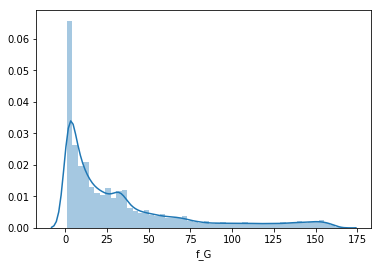

In [74]:
sns.distplot(df['f_G'].dropna())

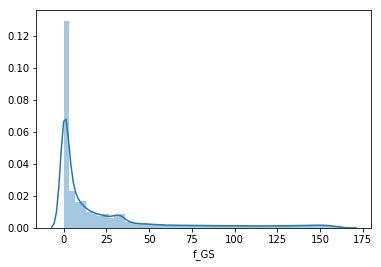

In [75]:
sns.distplot(df['f_GS'].dropna())

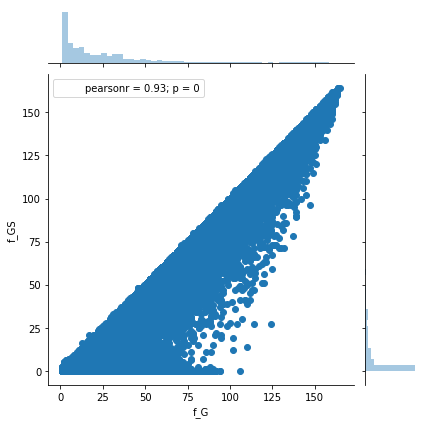

In [76]:
sns.jointplot(x="f_G", y="f_GS", data=df)

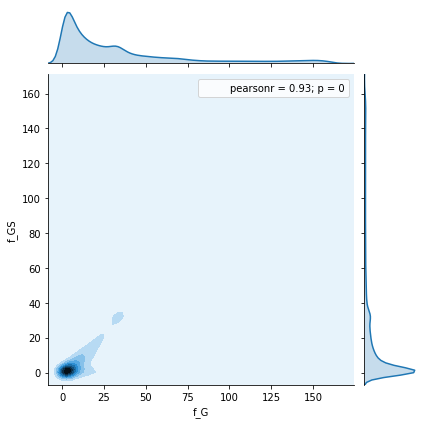

In [77]:
sns.jointplot(x="f_G", y="f_GS", data=df, kind='kde')

We're more interested in dropping players than particular seasons, so let's look at the career games played and started

In [78]:
df_fielding = df[['m_playerID', 'f_G', 'f_GS']]
df_fielding = df_fielding.groupby(['m_playerID'])[['f_G', 'f_GS']].sum()

df_batting = df[['m_playerID', 'b_G']]
df_batting = df_batting.groupby(['m_playerID'])[['b_G']].sum()

df_games_played = df_fielding.join(df_batting)
df_games_played.rename({'f_G': 'f_career_G', 'f_GS': 'f_career_GS', 'b_G': 'b_career_G'}, axis='columns', inplace=True)

df = df.join(df_games_played, on='m_playerID')
df_games_played.head()

,f_career_G,f_career_GS,b_career_G
m_playerID,,,
aardsda01,331.0,0.0,331.0
aaronha01,3020.0,2977.0,5252.0
aaronto01,387.0,206.0,1390.0
aasedo01,448.0,91.0,448.0
abadan01,9.0,4.0,24.0


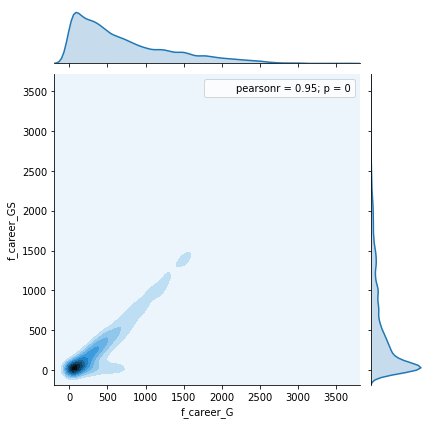

In [79]:
sns.jointplot(x="f_career_G", y="f_career_GS", data=df, kind='kde')

Lots of data in 0 to 500 games. Let's take a closer look there.

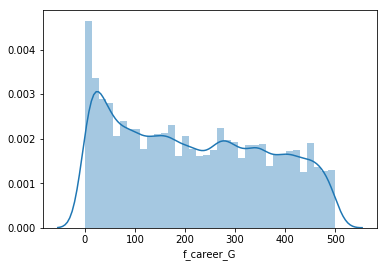

In [80]:
sns.distplot(df[df['f_career_G']<=500]['f_career_G'].dropna())

A baseball season was 154 games from 1920 to 1962 and 162 games from 1962 to present. This seems like a good cut off since the distibution seems to be roughly linear from about 150 games to 500 games. Let's see if cutting the data this way loses players that batted in a lot of games.

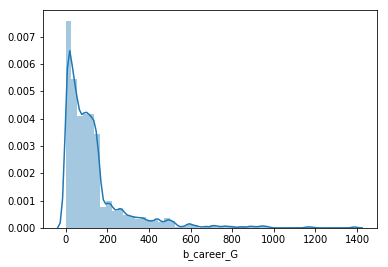

In [81]:
sns.distplot(df[df['f_career_G']<=162]['b_career_G'].dropna())


So it seems like there are a number of players that batted in a significant number of games without fielding in them. So, we'll drop players that batted in fewer then 162 games and fielded in fewer then 162 games.

In [82]:
df = df[(df['f_career_G']>162) | (df['b_career_G']>162)]
df['m_playerID'].nunique()

5182

## Drop those who didn't play as an outfielder
The scope of this notebook is outfielders, so we'll focus on them.

In [83]:
df['f_POS'].value_counts()

P     24971
OF    17932
1B     9712
3B     9540
2B     8337
SS     7300
C      6044
Name: f_POS, dtype: int64

In [84]:
df[df['f_POS']=='OF']['m_playerID'].nunique()

2371

We have 2371 outfielders, but did some of these players play other positions and if so, how should we handle them?

In [93]:
outfielders = df[df['f_POS']=='OF']['m_playerID'].unique()

df['f_outfielder'] = df['m_playerID'].apply(lambda x: x in outfielders)
pd.crosstab(df['f_POS'], df['f_outfielder'])

f_outfielder,False,True
f_POS,,
1B,2056,7656
2B,3215,5122
3B,3064,6476
C,3804,2240
OF,0,17932
P,23779,1192
SS,3302,3998


In [91]:
df.shape

(84313, 68)